In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import glob

from tqdm import tqdm
import seaborn as sns
from collections import Counter

import cv2

In [2]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

#import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

In [3]:
import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.neighbors import NearestNeighbors

In [4]:
train = pd.read_csv("/kaggle/happywhale/input/train.csv")
train.shape

(51033, 3)

In [5]:
train.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

In [6]:
from sklearn.preprocessing import normalize
from scipy.spatial import distance

In [7]:
import pickle

def load_emb(exp_names,pickle_name):
    # train/valid   train_all/test
    emb_lis = []
    for exp in exp_names:
        with open(exp + '/' + pickle_name + '.pickle', 'rb') as f:
            valid_preds = pickle.load(f)
        emb_lis.append(valid_preds)
    
    return normalize(np.concatenate(emb_lis,axis=1))
        

In [8]:
import pickle

def load_emb_weighted(exp_names,pickle_name,weights):
    # train/valid   train_all/test
    emb_lis = []
    for exp,w in zip(exp_names,weights):
        with open(exp + '/' + pickle_name + '.pickle', 'rb') as f:
            valid_preds = pickle.load(f)
        valid_preds *= w
        emb_lis.append(valid_preds)
    
    return normalize(np.concatenate(emb_lis,axis=1))
        

In [9]:
exps = [
    "aws_exp000","aws_exp001","aws_exp002","aws_exp003","aws_exp004", # backfin
    "exp093","exp098","exp099","exp100","exp101", # fullbody
    "aws_exp006","aws_exp007","aws_exp008","aws_exp009","aws_exp010", # ensemble
    "aws_exp022","aws_exp023","aws_exp024","aws_exp025","aws_exp026", # backfin_ensemble_species
    "exp113","exp114","exp115","exp116","exp117", # new_ensemble
    
    "aws_exp028","aws_exp029","aws_exp030","aws_exp031","aws_exp032", # backfin_ensemble_species_long
    "exp118","exp119","exp120","exp121","exp122", # new_ensemble_900600
    "exp047","exp050","exp051","exp052","exp054", # backfin_croped
    
]

In [10]:
assert(len(exps) == len(set(exps)))

In [11]:
def get_map(valid_preds, train_preds,valid_df,train_df):

    distances = cuml.metrics.pairwise_distances(valid_preds,train_preds)

    K=min(1000,len(train_df)-1)
    predicted_positions = np.argpartition(distances, K, axis=1)[:, :K]

    score_lis = []
    pred_ids = []
    corredt_ids  = []
    hit_species=defaultdict(int)
    count_species=defaultdict(int)

    train_inddividual_id_lis = train_df["individual_id"].values
    valid_inddividual_id_lis = valid_df["individual_id"].values

    rank_lis=[]

    for i in tqdm(range(predicted_positions.shape[0])):
        nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
        nearest.sort(key=lambda x: x[1])

        prediction = [index_id for index_id, d in nearest]

        done = set()
        pred_list = []
        for pred_id in prediction:
            if pred_id in done:
                continue
            done.add(pred_id)
            pred_list.append(pred_id)
            if len(pred_list)==5:
                break
        pred_ids.append(pred_list)

        if valid_inddividual_id_lis[i] in pred_list:
            s = 1/(pred_list.index(valid_inddividual_id_lis[i]) + 1)
            score_lis.append(s)
            rank_lis.append(pred_list.index(valid_inddividual_id_lis[i]))
        else:
            score_lis.append(0)
            rank_lis.append(5)

        
    return score_lis

In [12]:
def get_score(species,exps,weights):
    train_preds = load_emb_weighted(exps,"train",weights)
    valid_preds = load_emb_weighted(exps,"valid",weights)
    
    species_train_df = train_df.query("species in @species")
    species_valid_df = valid_df_for_train.query("species in @species")

    train_preds = train_preds[species_train_df.index]
    valid_preds = valid_preds[species_valid_df.index]
    
    return get_map(valid_preds,train_preds,species_valid_df,species_train_df)

In [13]:
result_df_4 = pd.read_csv("species_aware_weighted_average_0416_fold_4_final.csv")
result_df_3 = pd.read_csv("species_aware_weighted_average_0416_fold_3_final.csv")
result_df_2 = pd.read_csv("species_aware_weighted_average_0416_fold_2_final.csv")
result_df_1 = pd.read_csv("species_aware_weighted_average_0416_fold_1_final.csv")
result_df_0 = pd.read_csv("species_aware_weighted_average_0416_fold_0_final.csv")

In [14]:
print(result_df_3.shape)
print(result_df_4.shape)

(13, 10)
(13, 10)


In [15]:
result_df_3.head()

,species,backfin,fullbody,ensemble,backfin_ensemble_spe,new_ensemble,backfin_ensemble_spe_new,new_ensemble_900600,backfin_croped,best
0,blue_whale,1,2.793458,0.323647,0.805659,1.962065,0.805659,1.962065,2.653752,0.589443
1,beluga,1,3.926540,2.426636,3.075337,3.032417,3.075337,3.032417,1.914637,0.767939
2,gray_whale,1,3.089329,1.263204,2.682844,0.861244,2.682844,0.861244,2.297280,0.822330
3,dusky_dolphin,1,0.836969,0.288020,2.616178,2.955244,2.616178,2.955244,2.591753,0.861358
4,fin_whale,1,3.943746,1.877433,2.341293,1.959678,2.341293,1.959678,2.946659,0.907728


In [16]:
result_df = pd.DataFrame()

result_df["species"]  = result_df_0["species"]
result_df["backfin"]  = 1

keys=["fullbody","ensemble","backfin_ensemble_spe","new_ensemble","backfin_ensemble_spe_new","new_ensemble_900600","backfin_croped"]
for key in keys:
    result_df[key] = (result_df_4[key] + result_df_3[key] + result_df_2[key] + result_df_1[key] + result_df_0[key] )/5


In [17]:
result_df

,species,backfin,fullbody,ensemble,backfin_ensemble_spe,new_ensemble,backfin_ensemble_spe_new,new_ensemble_900600,backfin_croped
0,blue_whale,1,3.282420,0.332993,1.008228,2.603367,1.008228,2.603367,3.209371
1,beluga,1,3.604818,2.121889,1.380604,2.525593,1.380604,2.525593,1.756786
2,gray_whale,1,3.115138,2.582002,1.414420,2.383957,1.414420,2.383957,2.842479
3,dusky_dolphin,1,0.942475,0.849297,2.424276,2.911747,2.424276,2.911747,1.165269
4,fin_whale,1,2.426497,1.823028,2.565163,1.778826,2.565163,1.778826,2.153464
5,humpback_whale,1,3.629925,1.834447,2.293998,1.607656,2.293998,1.607656,2.938796
6,spinner_dolphin,1,0.988060,1.278206,1.998314,1.567223,1.998314,1.567223,1.777158
7,melon_headed_whale,1,1.885502,0.593717,2.707340,1.751863,2.707340,1.751863,2.130405
8,killer_whale,1,2.679921,1.935781,3.134198,1.527681,3.134198,1.527681,2.431447
9,minke_whale,1,1.982170,2.153529,3.358722,1.751322,3.358722,1.751322,2.362938


### test

In [18]:
test_df =pd.read_csv("../input/sample_submission.csv")
test_df.shape

(27956, 2)

In [19]:
test_preds      = load_emb(exps,"test")
train_all_preds = load_emb(exps,"train_all")

In [20]:
print(test_preds.shape)
print(train_all_preds.shape)

(27956, 20480)
(51033, 20480)


### predict nearest species

In [21]:
from sklearn.metrics import pairwise_distances

In [22]:
%%time

#distances = cuml.metrics.pairwise_distances(test_preds,train_all_preds)
distances = pairwise_distances(test_preds,train_all_preds)

CPU times: user 26min 45s, sys: 2min 54s, total: 29min 39s
Wall time: 2min 6s


In [23]:
%%time

K=1
predicted_positions = np.argpartition(distances, K, axis=1)[:, :K]

CPU times: user 3.54 s, sys: 1.08 s, total: 4.63 s
Wall time: 4.62 s


In [24]:
predicted_positions.shape

(27956, 1)

In [25]:
train_species_lis = train.species.values
test_pred_species = []


for i in range(len(predicted_positions)):
    train_species = train_species_lis[predicted_positions[i]][0]
    test_pred_species.append(train_species)

In [26]:
test_df["species"] = test_pred_species

In [27]:
Counter(test_pred_species)

Counter({'gray_whale': 643,
         'false_killer_whale': 1775,
         'beluga': 4324,
         'humpback_whale': 4567,
         'dusky_dolphin': 2260,
         'melon_headed_whale': 1122,
         'bottlenose_dolphin': 4423,
         'spinner_dolphin': 1314,
         'cuviers_beaked_whale': 371,
         'southern_right_whale': 660,
         'blue_whale': 1168,
         'killer_whale': 1564,
         'pygmy_killer_whale': 56,
         'fin_whale': 830,
         'long_finned_pilot_whale': 196,
         'sei_whale': 282,
         'pantropic_spotted_dolphin': 86,
         'minke_whale': 558,
         'common_dolphin': 193,
         'spotted_dolphin': 355,
         'short_finned_pilot_whale': 830,
         'white_sided_dolphin': 151,
         'brydes_whale': 101,
         'commersons_dolphin': 78,
         'rough_toothed_dolphin': 43,
         'frasiers_dolphin': 6})

In [28]:
test_df.head()

,image,predictions,species
0,000110707af0ba.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,gray_whale
1,0006287ec424cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,false_killer_whale
2,000809ecb2ccad.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,beluga
3,00098d1376dab2.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,humpback_whale
4,000b8d89c738bd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,dusky_dolphin


### weighted

In [29]:
species_count_valid_df = pd.read_csv("species_count_valid_df.csv")
species_count_valid_df.shape
minor_species = species_count_valid_df[species_count_valid_df["count"] <= 100].species.values
len(minor_species)

13

In [30]:
test_preds      = load_emb(exps,"test")
train_all_preds = load_emb(exps,"train_all")

In [31]:
print(test_preds.shape)
print(train_all_preds.shape)

(27956, 20480)
(51033, 20480)


In [32]:
emb_all_len = train_all_preds.shape[1]
fold_emb_len = 512*5

In [33]:
result_df

,species,backfin,fullbody,ensemble,backfin_ensemble_spe,new_ensemble,backfin_ensemble_spe_new,new_ensemble_900600,backfin_croped
0,blue_whale,1,3.282420,0.332993,1.008228,2.603367,1.008228,2.603367,3.209371
1,beluga,1,3.604818,2.121889,1.380604,2.525593,1.380604,2.525593,1.756786
2,gray_whale,1,3.115138,2.582002,1.414420,2.383957,1.414420,2.383957,2.842479
3,dusky_dolphin,1,0.942475,0.849297,2.424276,2.911747,2.424276,2.911747,1.165269
4,fin_whale,1,2.426497,1.823028,2.565163,1.778826,2.565163,1.778826,2.153464
5,humpback_whale,1,3.629925,1.834447,2.293998,1.607656,2.293998,1.607656,2.938796
6,spinner_dolphin,1,0.988060,1.278206,1.998314,1.567223,1.998314,1.567223,1.777158
7,melon_headed_whale,1,1.885502,0.593717,2.707340,1.751863,2.707340,1.751863,2.130405
8,killer_whale,1,2.679921,1.935781,3.134198,1.527681,3.134198,1.527681,2.431447
9,minke_whale,1,1.982170,2.153529,3.358722,1.751322,3.358722,1.751322,2.362938


In [34]:
spe_lis = list(set(result_df.species))

for spe in  spe_lis:
   # print(spe)
    if spe in minor_species or spe=="frasiers_dolphin":
        #weight = np.array([1] * emb_all_len)       
        continue

    backfin=1
    fullbody=result_df.query("species == @spe").iloc[0].fullbody
    ensemble=result_df.query("species == @spe").iloc[0].ensemble
    backfin_ensemble=result_df.query("species == @spe").iloc[0].backfin_ensemble_spe
    new_ensemble=result_df.query("species == @spe").iloc[0].new_ensemble
    
    backfin_ensemble_spe_new=result_df.query("species == @spe").iloc[0].backfin_ensemble_spe_new
    new_ensemble_900600=result_df.query("species == @spe").iloc[0].new_ensemble_900600
    backfin_croped=result_df.query("species == @spe").iloc[0].backfin_croped
    
    weight=(
        [backfin] * fold_emb_len + 
        [fullbody] * fold_emb_len + 
        [ensemble] * fold_emb_len  + 
        [backfin_ensemble] * fold_emb_len +
        [new_ensemble] * fold_emb_len +
        
        [backfin_ensemble_spe_new] * fold_emb_len +
        [new_ensemble_900600] * fold_emb_len +
        [backfin_croped] * fold_emb_len 
    )
    
    train_ind = train.query("species == @spe").index
    test_ind = test_df.query("species == @spe").index
    
    train_all_preds[train_ind] *= weight
    test_preds[test_ind] *= weight

In [35]:
train_all_preds=normalize(train_all_preds)
test_preds=normalize(test_preds)

In [36]:
train_all_preds.shape, test_preds.shape

((51033, 20480), (27956, 20480))

In [37]:
%%time

distances = pairwise_distances(test_preds,train_all_preds)

#distances = cuml.metrics.pairwise_distances(test_preds,train_all_preds)

CPU times: user 26min 47s, sys: 3min 9s, total: 29min 57s
Wall time: 2min 8s


In [38]:
%%time

K=1000
predicted_positions = np.argpartition(distances, K, axis=1)[:, :K]

CPU times: user 10.8 s, sys: 992 ms, total: 11.7 s
Wall time: 11.7 s


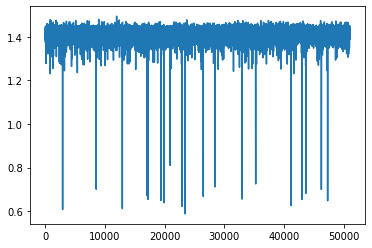

In [39]:
plt.plot(distances[0])

In [40]:
sub_pred_lis = []

train_inddividual_id_lis = train["individual_id"].values


for i in tqdm(range(predicted_positions.shape[0])):
    nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
    nearest.sort(key=lambda x: x[1])

    prediction = [index_id for index_id, d in nearest]
    
    done = set()
    pred_list = []
    for pred_id in prediction:
        if pred_id in done:
            continue
        done.add(pred_id)
        pred_list.append(pred_id)
        if len(pred_list)==10:
            break    

            
    sub_pred_lis.append(pred_list)

100%|██████████| 27956/27956 [00:26<00:00, 1036.32it/s]


In [41]:
pred_lis_joined = []
for preds in sub_pred_lis:
    pred_lis_joined.append(" ".join(preds))

In [42]:
test_df["predictions"] = pred_lis_joined

In [43]:
#test_df[["image","predictions"]].to_csv("submission_weighted_" +"_".join(exps)+ ".csv",index=None)

In [44]:
test_df

,image,predictions,species
0,000110707af0ba.jpg,fbe2b15b5481 574bd81ec992 6d1cc6d00dca 19a3c80...,gray_whale
1,0006287ec424cb.jpg,1424c7fec826 c3b7d902e73c f0efb5bcc5d3 5325e39...,false_killer_whale
2,000809ecb2ccad.jpg,1ce3ba6a3c29 82f26bb1adae 463280e75202 b8125d9...,beluga
3,00098d1376dab2.jpg,c4274d90be60 2781acdf5508 8b7c29052b93 2f2e8ad...,humpback_whale
4,000b8d89c738bd.jpg,cf500d3874bc d4d2cd407a48 56637d420170 ef2bf7f...,dusky_dolphin
...,...,...,...
27951,fff6ff1989b5cd.jpg,734573d54bef 843297d1983b ec0aa394b7e5 5b64c9d...,spinner_dolphin
27952,fff8fd932b42cb.jpg,539541f81a32 b7bd57892597 4dbb6ebf48a2 1a455af...,dusky_dolphin
27953,fff96371332c16.jpg,2fad3a13934d dc4082105594 8949de1830d1 fd983ad...,beluga
27954,fffc1c4d3eabc7.jpg,a8fe10f7b3e0 e7f9e93184b9 a3c1d585d138 fd53cdc...,cuviers_beaked_whale


### set new_individual_cnt

In [45]:
#test_new_ind_cnt_df = pd.read_csv("../input/test_new_ind_ratio_0328.csv")
test_new_ind_cnt_df = pd.read_csv("../input/test_new_ind_ratio_0402.csv")

In [46]:
spe_lis = test_new_ind_cnt_df.species.values

In [47]:
test_new_ind_cnt_df

,species,test_new_ind_ratio
0,humpback_whale,0.097941
1,bottlenose_dolphin,0.025106
2,beluga,0.006468
3,dusky_dolphin,0.523474
4,false_killer_whale,0.015609
5,killer_whale,0.017829
6,spinner_dolphin,0.064464
7,blue_whale,0.048034
8,melon_headed_whale,0.376427
9,fin_whale,0.101046


In [48]:
def get_thr(spe,ratio_target_df,top1=True,multiplier=1.0):
    spe_ind_lis = test_df.query("species == @spe").index.values
    sub_pred_lis=[]
    
    for i in spe_ind_lis:
        nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
        nearest.sort(key=lambda x: x[1])

        prediction = [index_id for index_id, d in nearest]
        dists = [d for index_id, d in nearest]

        done = set()
        dist_list = []
        for pred_id,dist in zip(prediction,dists):
            if pred_id in done:
                continue
            done.add(pred_id)
            dist_list.append(dist)
            if len(dist_list)==5:
                break    


        sub_pred_lis.append(dist_list)
    
    
    
    ratio_target = multiplier * ratio_target_df.query("species == @spe").iloc[0]["test_new_ind_ratio"]
    
    return binary(sub_pred_lis,ratio_target,top1)

In [49]:
def solve(sub_pred_lis,mid,target_ratio):
    ratio_lis = []
    for i in range(len(sub_pred_lis)):
        ratio = 0
        for j in range(5):
            if sub_pred_lis[i][j] > mid: # j is new_ind
                ratio = 1/(j+1)
                break
        
        ratio_lis.append(ratio)
    return np.mean(ratio_lis) < target_ratio

def solve_top1(sub_pred_lis,mid,target_ratio):
    ratio_lis = []
    for i in range(len(sub_pred_lis)):
        ratio = 0
        for j in range(5):
            if sub_pred_lis[i][0] > mid: 
                ratio = 1
                break
        
        ratio_lis.append(ratio)
    return np.mean(ratio_lis) < target_ratio

def binary(sub_pred_lis,target_ratio,top1):
    ok=2
    ng=0
    cnt=0
    while cnt<100:
        cnt+=1
        mid = (ok+ng)/2
        #ret = solve(sub_pred_lis,mid,target_ratio)
        if top1:
            ret = solve_top1(sub_pred_lis,mid,target_ratio)
        else:
            ret = solve(sub_pred_lis,mid,target_ratio)
            
        if ret:
            ok=mid
        else:
            ng=mid
    return ok

In [50]:
get_thr("beluga",test_new_ind_cnt_df,top1=True,multiplier=0.5)

1.223181128501892

In [51]:
MULTIPLIER=1.3

In [52]:
thr_lis_top1 = []
for spe in tqdm(spe_lis):
    thr = get_thr(spe,test_new_ind_cnt_df,top1=True,multiplier=MULTIPLIER)
    thr_lis_top1.append(thr)

100%|██████████| 26/26 [00:47<00:00,  1.83s/it]


In [53]:
thr_df = pd.DataFrame()
thr_df["species"] = spe_lis
thr_df["thr"] = thr_lis_top1


In [54]:
thr_df

,species,thr
0,humpback_whale,1.181594
1,bottlenose_dolphin,1.142259
2,beluga,1.203657
3,dusky_dolphin,0.999866
4,false_killer_whale,1.126398
5,killer_whale,1.179332
6,spinner_dolphin,1.131939
7,blue_whale,1.199804
8,melon_headed_whale,1.017151
9,fin_whale,1.132193


In [62]:
sub_pred_lis = []

train_inddividual_id_lis = train["individual_id"].values
new_ind_1_cnt=0

new_ind_index_lis = [] # 1, 0.5 ,0.33, 0.25, 0.2

for i in tqdm(range(predicted_positions.shape[0])):
    nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
    
    nearest.sort(key=lambda x: x[1])
    
    spe = test_pred_species[i]
    new_individual_thr = thr_df.query("species == @spe").iloc[0].thr

    done = set()
    pred_list = []
    new_ind_ind = 0
    for pred_id, score in nearest:
        if score > new_individual_thr and not "new_individual" in done:
            pred_list.append("new_individual")
            done.add("new_individual")
            new_ind_index_lis.append(1/len(pred_list))
            
        if pred_id in done:
            continue
        done.add(pred_id)
        pred_list.append(pred_id)
        if len(pred_list)>=10:
            break    

    if pred_list[0]=="new_individual":
        new_ind_1_cnt+=1
    sub_pred_lis.append(pred_list)

100%|██████████| 27956/27956 [01:03<00:00, 441.65it/s]


In [63]:
new_ind_1_cnt/len(test_df)

0.1430462154814709

In [64]:
np.mean(new_ind_index_lis)

0.4662808345783406

In [65]:
pred_lis_joined = []
for preds in sub_pred_lis:
    pred_lis_joined.append(" ".join(preds))

In [66]:
test_df["predictions"] = pred_lis_joined

In [67]:
test_df[["image","predictions"]].to_csv("submission_multi_" +str(MULTIPLIER)+"_s_shohei_40models.csv",index=None)

In [68]:
test_df

,image,predictions,species
0,000110707af0ba.jpg,fbe2b15b5481 new_individual 574bd81ec992 6d1cc...,gray_whale
1,0006287ec424cb.jpg,1424c7fec826 new_individual c3b7d902e73c f0efb...,false_killer_whale
2,000809ecb2ccad.jpg,1ce3ba6a3c29 82f26bb1adae 463280e75202 b8125d9...,beluga
3,00098d1376dab2.jpg,c4274d90be60 2781acdf5508 8b7c29052b93 new_ind...,humpback_whale
4,000b8d89c738bd.jpg,cf500d3874bc new_individual d4d2cd407a48 56637...,dusky_dolphin
...,...,...,...
27951,fff6ff1989b5cd.jpg,734573d54bef 843297d1983b new_individual ec0aa...,spinner_dolphin
27952,fff8fd932b42cb.jpg,new_individual 539541f81a32 b7bd57892597 4dbb6...,dusky_dolphin
27953,fff96371332c16.jpg,2fad3a13934d dc4082105594 8949de1830d1 fd983ad...,beluga
27954,fffc1c4d3eabc7.jpg,new_individual a8fe10f7b3e0 e7f9e93184b9 a3c1d...,cuviers_beaked_whale
